### Importing Libraries

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import arch
from datetime import datetime
import matplotlib.pyplot as plt

### Download SPY data

In [2]:
spy = yf.download('SPY', start='2020-01-01', end=datetime.now().strftime('%Y-%m-%d'))
returns = 100 * spy['Adj Close'].pct_change().dropna()

# Check first 2 and last 2 rows
pd.concat([spy.head(2), spy.tail(2)])

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,323.540009,324.890015,322.529999,324.869995,301.194885,59151200
2020-01-03,321.160004,323.640015,321.100006,322.410004,298.914185,77709700
2024-12-19,591.359985,593.000000,585.849976,586.099976,584.133972,85919500
2024-12-20,581.770020,595.750000,580.909973,591.150024,591.150024,125535900


### Plot Closing (adj) prices

[Text(0.5, 1.0, 'SPY'), Text(0, 0.5, 'Price')]

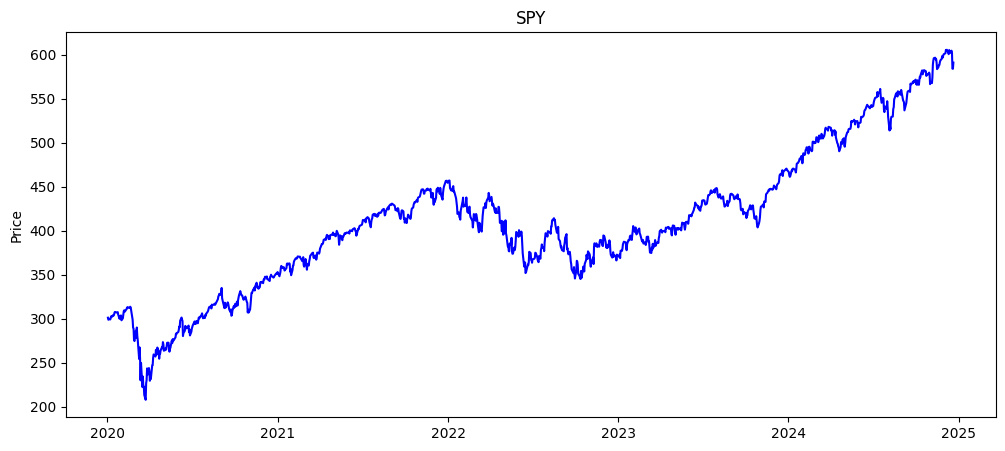

In [3]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(spy['Adj Close'], color='blue')
ax.set(title='SPY', ylabel='Price')

### Applying GARCH(1,1) to SPY returns

In [57]:
model = arch.arch_model(returns, mean='Zero', vol='GARCH', p=1, q=1, dist='normal')
results = model.fit(disp='off')
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -1824.41
Distribution:                  Normal   AIC:                           3654.82
Method:            Maximum Likelihood   BIC:                           3670.21
                                        No. Observations:                 1251
Date:                Mon, Dec 23 2024   Df Residuals:                     1251
Time:                        10:20:15   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0495  1.842e-02      2.685  7.250e-03 [1.336e-02,8.556e-02]
alpha[1]       0.1463  3.131e-02      4.675  2.944e-06   [8.499e-02,  0.208]
beta[1]        0.8193  3.687e-02     22.222 2.082e-109     [  0.747,  0.892]
============================================================================

Covariance estimator: robust
"""

### Plotting volatility to returns

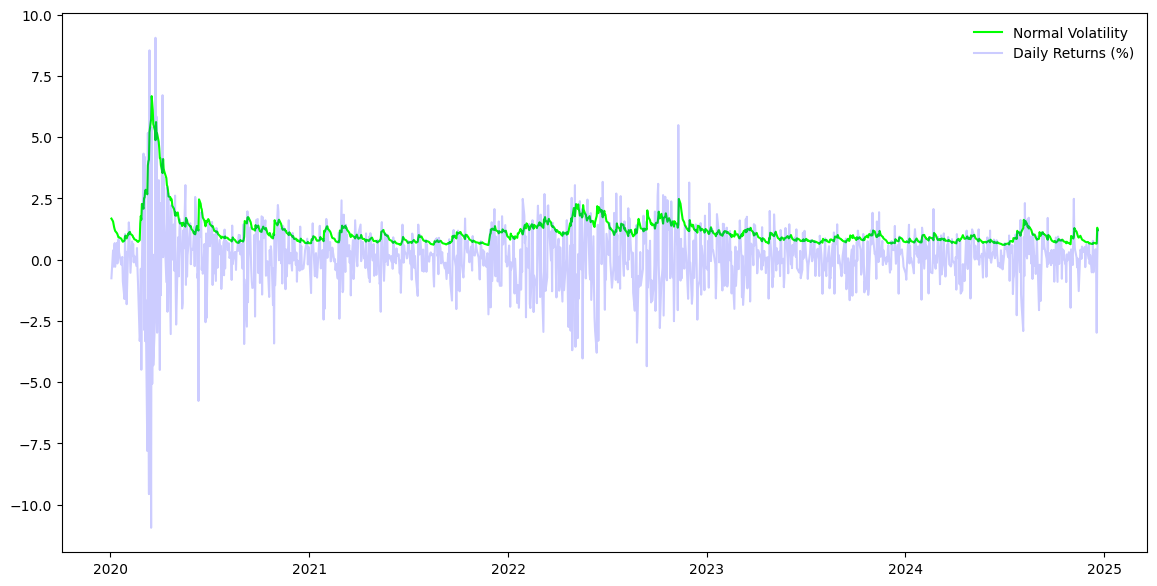

In [32]:
plt.figure(figsize=(14,7))
plt.plot(results.conditional_volatility, color = 'lime', label = 'Normal Volatility')
plt.plot(returns, color = 'blue', label = 'Daily Returns (%)', alpha = 0.2)
plt.legend(loc = 'upper right', frameon=False)

### Generate 5-day ahead forecasts

In [5]:
forecasts = results.forecast(horizon=5)
conditional_vol = np.sqrt(forecasts.variance.values[-1, :])

### Get in-sample volatility (forecasted)

In [52]:
# How it is calculated, with rolling window?
conditional_vol_in_sample = results.conditional_volatility
conditional_vol_in_sample.tail(2)

Date
2024-12-19    1.305463
2024-12-20    1.202476
Name: cond_vol, dtype: float64

### Realized volatility (21-day rolling)

In [53]:
realized_vol = returns.rolling(window=21).std()
realized_vol.tail(2)

Date
2024-12-19    0.780202
2024-12-20    0.825331
Name: Adj Close, dtype: float64

### Set regime thresholds based on historical percentiles

In [51]:
# Choose between conditional_vol_in_sample (forecasted volatility) OR realized_vol ???

vol_25th = np.percentile(conditional_vol_in_sample, 25)
vol_75th = np.percentile(conditional_vol_in_sample, 75)
vol_90th = np.percentile(conditional_vol_in_sample, 90)

print(f'90th prcentl: {vol_90th:.4f}',
      f'75th prcentl: {vol_75th:.4f}',
      f'25th prcentl: {vol_25th:.4f}', sep='\n')

90th prcentl: 1.6209
75th prcentl: 1.2635
25th prcentl: 0.7901


### Visualizing volatility and regimes' thresholds

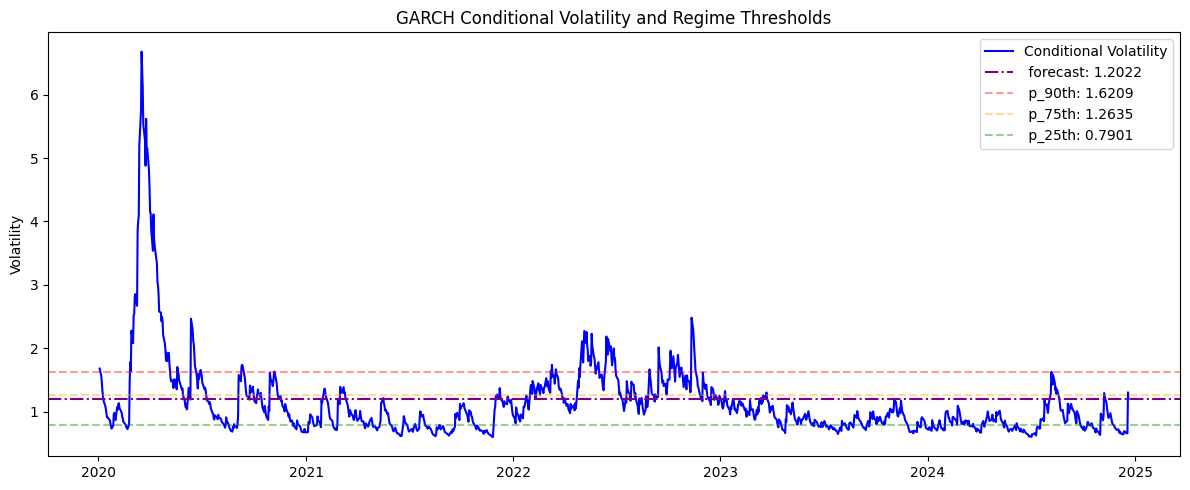

In [56]:
# Classification of regimes
regimes = pd.Series(index=returns.index, data='Normal Vol')
regimes[conditional_vol_in_sample < vol_25th] = 'Low Vol'
regimes[conditional_vol_in_sample > vol_75th] = 'High Vol'
regimes[conditional_vol_in_sample > vol_90th] = 'Crisis'

# Plotting
plt.figure(figsize=(12, 5))
plt.plot(returns.index, conditional_vol_in_sample, label='Conditional Volatility', color='blue')
plt.axhline(y=conditional_vol[0], color='purple', linestyle='-.', label=f' forecast: {conditional_vol[0]:.4f}')
plt.axhline(y=vol_90th, color='red', linestyle='--', label=f' p_90th: {vol_90th:.4f}', alpha=0.4)
plt.axhline(y=vol_75th, color='orange', linestyle='--', label=f' p_75th: {vol_75th:.4f}', alpha=0.4)
plt.axhline(y=vol_25th, color='green', linestyle='--', label=f' p_25th: {vol_25th:.4f}', alpha=0.4)
plt.title('GARCH Conditional Volatility and Regime Thresholds')
plt.legend()
plt.ylabel('Volatility')
plt.tight_layout()
plt.show()

### Summary metrics

In [11]:
print("\nRegime Summary:")
print(regimes.value_counts())


Regime Summary:
Normal Vol    625
Low Vol       313
High Vol      188
Crisis        125
Name: count, dtype: int64
